<a href="https://colab.research.google.com/github/guptavasu1213/glaucoma-identification/blob/master/Unet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import os

In [3]:
%load_ext tensorboard
logs_base_dir = "drive/Shared drives/Capstone Summer 2020/Models/Unet_From_Scratch/runs"
os.makedirs(logs_base_dir, exist_ok=True)

In [4]:
from PIL import Image
import cv2
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict

import torch
import torch.nn as nn
import torch.nn.functional as F

import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
from torch.optim import lr_scheduler
from torch.utils.data import Dataset as BaseDataset
# from torchvision.transforms import functional
from torchvision import transforms
from tqdm.notebook import tqdm 
import time

In [5]:
ROOT_PATH = 'drive/Shared drives/Capstone Summer 2020/Data/'

In [6]:
# !rm drive/Shared\ drives/Capstone\ Summer\ 2020/Models/Unet_From_Scratch/runs/events*

In [7]:
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

class VisModel:
    def __init__(self, model, criterion, optimizer, device, dataloaders, dataset_sizes):
        self.model = model
        self.criterion = criterion
        self.optimizer = optimizer
        self.device = device
        self.dataloaders = dataloaders
        self.dataset_sizes = dataset_sizes
        interact(self.choose_instance, instance_id=range(dataset_sizes['Training']))
            
    def choose_instance(self, instance_id):
        self.original_image = self.dataloaders['Training'][instance_id][0]
        self.mask = self.dataloaders['Training'][instance_id][1]
        
        plt.imshow(transforms.ToPILImage()(self.original_image.detach().cpu()), interpolation="bicubic")

        interact(self.filter_modules, show_all_modules=False)
        
    def filter_modules(self, show_all_modules):
        modules = []
        for name, module in self.model.named_modules():
            if not show_all_modules and '.' in name:
                continue
            modules.append((name, module))
        interact(self.select_module, module=modules)
        
    def forward_module_hook(self, module, input, output):
        if isinstance(output, tuple):
            activations = []
            for activation in output:
                print(activation.shape)
                activations.append(np.flip(activation.detach().cpu().numpy(), axis=2).squeeze())
            self.activation = np.expand_dims(np.array(activations), 0)
        else:
            self.activation = np.flip(output.detach().cpu().numpy(), axis=2)

    def backward_module_hook(self, module, input, output):
        output = output[0]
        self.gradient = np.flip(output.detach().cpu().numpy(), axis=2)

    def select_module(self, module):
        forward_hook_handle = module.register_forward_hook(self.forward_module_hook)
        backward_hook_handle = module.register_backward_hook(self.backward_module_hook)
        
        self.original_image = self.original_image.to(self.device)
        self.mask = self.mask.to(self.device)

        output = self.model(self.original_image.unsqueeze(0))
        loss = self.criterion(output, self.mask.squeeze(1).type(torch.long))
        self.optimizer.zero_grad()
        loss.backward()

        forward_hook_handle.remove()
        backward_hook_handle.remove()
        
        print(self.activation.shape)
        C = self.activation.shape[1]
        cmaps = ['gray', "viridis", 'plasma', 'inferno', 'magma', 'cividis']
        interact(self.activation_plot, cmap=cmaps, channel=(0, C - 1), show_gradient=False, range=(1.0, 10.0))
        
    def activation_plot(self, cmap, channel, show_gradient, range):
        if show_gradient:
            image = self.gradient
        else:
            image = self.activation

        plt.figure(figsize=(12, 12))
        plt.tick_params(which='both', bottom=False, top=False, left=False, labelbottom=False, labelleft=False)
        mean = np.mean(image[0, channel])
        std = np.std(image[0, channel])
        plt.imshow(image[0, channel], cmap=cmap, vmin=mean-std * range, vmax=mean + std * range, interpolation='nearest', origin='lower')
        plt.colorbar(shrink=0.5)
        

In [8]:
# this dataset already contains the transforms
def fix_mask(mask):
  mask[mask == 128] = 1
  mask[mask == 255] = 2 # This should swap the black and white values
  return mask


class Dataset(BaseDataset):
  def __init__(self, root_dir, scale = 1):
    self.root_dir = root_dir
    self.scale = scale
    self.images_dir = os.path.join(root_dir, 'Images')
    self.masks_dir = os.path.join(root_dir, 'Masks')
    self.ids = os.listdir(self.images_dir)
    self.maskids = os.listdir(self.masks_dir)

  @classmethod
  def preprocess(cls, pil_img, scale):
    w, h = pil_img.size
    newW, newH = int(scale * w), int(scale * h)
    assert newW > 0 and newH > 0, 'Scale is too small'
    pil_img = pil_img.resize((newW, newH), resample=Image.NEAREST)

    img_nd = np.array(pil_img)
    # print(np.unique(img_nd))

    if len(img_nd.shape) == 2:
      img_nd = np.expand_dims(img_nd, axis=2)
  
    # HWC to CHW
    img_trans = img_nd.transpose((2, 0, 1))
    if img_trans.max() > 1:
      img_trans = img_trans / 255

    return img_trans

  def __getitem__(self, idx):
    #load images and masks
    img_path = os.path.join(self.images_dir, self.ids[idx])
    mask_path = os.path.join(self.masks_dir, self.maskids[idx])
    img = Image.open(img_path).convert("RGB")
    # mask = Image.open(mask_path).convert('L')
    mask = Image.open(mask_path)
    
    label = 0 if self.ids[idx][0] == 'n' else 1 # this isn't being used at the moment

    img = self.preprocess(img, self.scale)
    mask = self.preprocess(mask, self.scale)*2

    return torch.from_numpy(img).type(torch.FloatTensor), torch.from_numpy(mask).long()
  
  def __len__(self):
    return len(self.ids)

[0.         0.00392157 0.00784314 0.01176471 0.01568628 0.01960784
 0.02352941 0.02745098 0.03137255 0.03529412 0.03921569 0.04313726
 0.04705882 0.05098039 0.05490196 0.05882353 0.0627451  0.06666667
 0.07058824 0.07450981 0.07843138 0.08235294 0.08627451 0.09019608
 0.09411765 0.09803922 0.10196079 0.10588235 0.10980392 0.11372549
 0.11764706 0.12156863 0.1254902  0.12941177 0.13333334 0.13725491
 0.14117648 0.14509805 0.14901961 0.15294118 0.15686275 0.16078432
 0.16470589 0.16862746 0.17254902 0.1764706  0.18039216 0.18431373
 0.1882353  0.19215687 0.19607843 0.2        0.20392157 0.20784314
 0.21176471 0.21568628 0.21960784 0.22352941 0.22745098 0.23137255
 0.23529412 0.23921569 0.24313726 0.24705882 0.2509804  0.25490198
 0.25882354 0.2627451  0.26666668 0.27058825 0.27450982 0.2784314
 0.28235295 0.28627452 0.2901961  0.29411766 0.29803923 0.3019608
 0.30588236 0.30980393 0.3137255  0.31764707 0.32156864 0.3254902
 0.32941177 0.33333334 0.3372549  0.34117648 0.34509805 0.3490196

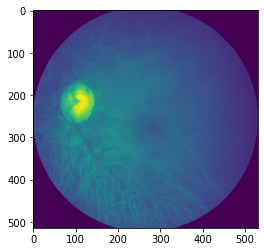

In [9]:
batch_size = 4
datasets = {x: Dataset(os.path.join(ROOT_PATH, x), scale=0.25) for x in ['Training', 'Validation']}
dataloaders = {x: DataLoader(datasets[x], batch_size=batch_size, shuffle=True, num_workers=4) for x in ['Training', 'Validation']}
dataset_sizes = {x: len(datasets[x]) for x in ['Training', 'Validation'] }
n_train = dataset_sizes['Training']
n_val = dataset_sizes['Validation']

# testing the gt
d = datasets['Training'][0][0]
print(np.unique(d))
print(d.shape)

plt.imshow(d[0])

#Unet

In [10]:
""" Parts of the U-Net model """

import torch
import torch.nn as nn
import torch.nn.functional as F


class DoubleConv(nn.Module):
  """(convolution => [BN] => ReLU) * 2"""

  def __init__(self, in_channels, out_channels, mid_channels=None):
    super().__init__()
    if not mid_channels:
      mid_channels = out_channels
    self.double_conv = nn.Sequential(
      nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1),
      nn.BatchNorm2d(mid_channels),
      # nn.ReLU(inplace=True),
      nn.LeakyReLU(negative_slope = 0.01, inplace=True),
      nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1),
      nn.BatchNorm2d(out_channels),
      # nn.ReLU(inplace=True),
      nn.LeakyReLU(negative_slope = 0.01, inplace=True))
      # nn.Dropout2d(p=0.25)) #TWEAK HYPERPARAMETER P 

  def forward(self, x):
    return self.double_conv(x)


class Down(nn.Module):
  """Downscaling with maxpool then double conv"""

  def __init__(self, in_channels, out_channels):
    super().__init__()
    self.maxpool_conv = nn.Sequential(
      nn.MaxPool2d(2),
      DoubleConv(in_channels, out_channels))

  def forward(self, x):
    return self.maxpool_conv(x)


class Up(nn.Module):
  """Upscaling then double conv"""

  def __init__(self, in_channels, out_channels, bilinear=True):
    super().__init__()

    # if bilinear, use the normal convolutions to reduce the number of channels
    if bilinear:
      self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
      self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
    else:
      self.up = nn.ConvTranspose2d(in_channels , in_channels // 2, kernel_size=2, stride=2)
      self.conv = DoubleConv(in_channels, out_channels)


  def forward(self, x1, x2):
    x1 = self.up(x1)
    # input is CHW
    diffY = x2.size()[2] - x1.size()[2]
    diffX = x2.size()[3] - x1.size()[3]

    x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                    diffY // 2, diffY - diffY // 2])
    # if you have padding issues, see
    # https://github.com/HaiyongJiang/U-Net-Pytorch-Unstructured-Buggy/commit/0e854509c2cea854e247a9c615f175f76fbb2e3a
    # https://github.com/xiaopeng-liao/Pytorch-UNet/commit/8ebac70e633bac59fc22bb5195e513d5832fb3bd
    x = torch.cat([x2, x1], dim=1)
    return self.conv(x)


class OutConv(nn.Module):
  def __init__(self, in_channels, out_channels):
    super(OutConv, self).__init__()
    self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

  def forward(self, x):
    return self.conv(x)

class UNet(nn.Module):
  def __init__(self, n_channels, n_classes, bilinear=True):
    super(UNet, self).__init__()
    self.n_channels = n_channels
    self.n_classes = n_classes
    self.bilinear = bilinear

    self.inc = DoubleConv(n_channels, 64)
    self.down1 = Down(64, 128)
    self.down2 = Down(128, 256)
    self.down3 = Down(256, 512)
    factor = 2 if bilinear else 1
    self.down4 = Down(512, 1024 // factor)
    self.up1 = Up(1024, 512 // factor, bilinear)
    self.up2 = Up(512, 256 // factor, bilinear)
    self.up3 = Up(256, 128 // factor, bilinear)
    self.up4 = Up(128, 64, bilinear)
    self.outc = OutConv(64, n_classes)

  def forward(self, x):
    x1 = self.inc(x)
    x2 = self.down1(x1)
    x3 = self.down2(x2)
    x4 = self.down3(x3)
    x5 = self.down4(x4)
    x = self.up1(x5, x4)
    x = self.up2(x, x3)
    x = self.up3(x, x2)
    x = self.up4(x, x1)
    logits = self.outc(x)
    return logits

In [11]:
# temporary
def dice_no_threshold(
  outputs: torch.Tensor,
  targets: torch.Tensor,
  eps: float = 1e-7,
  threshold: float = None):
  """
  Reference:
  https://catalyst-team.github.io/catalyst/_modules/catalyst/dl/utils/criterion/dice.html
  """
  if threshold is not None:
      outputs = (outputs > threshold).float()

  intersection = torch.sum(targets * outputs)
  union = torch.sum(targets) + torch.sum(outputs)
  dice = intersection / (union + eps)

  return dice

In [12]:
def train_model(model, criterion, optimizer, scheduler, n_epochs = 3):
  start = time.time()
  train_loss_list = []
  valid_loss_list = []
  dice_score_list = []
  lr_rate_list = []
  valid_loss_min = np.Inf # track change in validation loss

  writer = SummaryWriter(log_dir = logs_base_dir)

  for epoch in range(1, n_epochs+1):

    # keep track of training and validation loss
    train_loss = 0.0
    valid_loss = 0.0
    dice_score = 0.0
    ###################
    # train the model #
    ###################
    model.train()
    bar = tqdm(dataloaders['Training'], postfix={"train_loss":0.0})
    for data, target in bar:
        # move tensors to GPU if CUDA is available
        data, target = data.to(device), target.to(device)

        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss

        target = target.squeeze(1).type(torch.long)
        loss = criterion(output, target)
        #print(loss)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update training loss
        train_loss += loss.item()*data.size(0)
        bar.set_postfix(ordered_dict={"train_loss":loss.item()})
    ######################    
    # validate the model #
    ######################
    model.eval()
    del data, target
    with torch.no_grad():
        bar = tqdm(dataloaders['Validation'], postfix={"valid_loss":0.0, "dice_score":0.0})
        for data, target in bar:
            # move tensors to GPU if CUDA is available
            data, target = data.to(device), target.to(device)
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)
            # calculate the batch loss
            # target = target.squeeze(1).type(torch.long)
            loss = criterion(output, target.squeeze(1).type(torch.long))
            # update average validation loss 
            valid_loss += loss.item()*data.size(0)

            dice_cof = dice_no_threshold(output.cpu(), target.cpu()).item()
            dice_score +=  dice_cof * data.size(0)
            bar.set_postfix(ordered_dict={"valid_loss":loss.item(), "dice_score":dice_cof})
    
    # calculate average losses
    train_loss = train_loss/n_train
    valid_loss = valid_loss/n_val
    dice_score = dice_score/n_val
    train_loss_list.append(train_loss)
    valid_loss_list.append(valid_loss)
    dice_score_list.append(dice_score)
    lr_rate_list.append([param_group['lr'] for param_group in optimizer.param_groups])
    
    # print training/validation statistics 
    print('Epoch: {}  Training Loss: {:.6f}  Validation Loss: {:.6f} Dice Score: {:.6f}'.format(
        epoch, train_loss, valid_loss, dice_score))
    
    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), 'model_cifar.pt')
        valid_loss_min = valid_loss
    
    scheduler.step()

  time_elapsed = time.time() - start
  print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
  torch.save(model.state_dict(), 'drive/Shared drives/Capstone Summer 2020/Models/Unet_From_Scratch/Laroy_UNet-NoDropout.pth')
  return model, train_loss_list, valid_loss_list, dice_score_list, lr_rate_list

##TODO
*change criterion to hybriddiceloss function provided by cory

In [13]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = UNet(3,3)
model.to(device)

lr = 0.01
criterion = nn.CrossEntropyLoss() # TODO 
optimizer = optim.Adam(model.parameters(), lr=lr)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)


/usr/local/lib/python3.6/dist-packages/torch/cuda/__init__.py:125: UserWarning: 
Tesla T4 with CUDA capability sm_75 is not compatible with the current PyTorch installation.
The current PyTorch install supports CUDA capabilities sm_37 sm_50 sm_60 sm_70.
If you want to use the Tesla T4 GPU with PyTorch, please check the instructions at https://pytorch.org/get-started/locally/

  warnings.warn(incompatible_device_warn.format(device_name, capability, " ".join(arch_list), device_name))


In [28]:

# model.load_state_dict(torch.load('drive/Shared drives/Capstone Summer 2020/Models/Unet_From_Scratch/Laroy_UNet-NoDropout.pth'))

# VisModel(model, criterion, optimizer, device, datasets, dataset_sizes)

In [29]:
 model, train_loss_list, valid_loss_list, dice_score_list, lr_rate_list = train_model(model, criterion, optimizer, exp_lr_scheduler, n_epochs=10)


Epoch: 1  Training Loss: 0.101340  Validation Loss: 0.139725 Dice Score: 11.747067
Validation loss decreased (inf --> 0.139725).  Saving model ...



Epoch: 2  Training Loss: 0.052653  Validation Loss: 0.067364 Dice Score: 6.761237
Validation loss decreased (0.139725 --> 0.067364).  Saving model ...



Epoch: 3  Training Loss: 0.051373  Validation Loss: 0.204863 Dice Score: 8.927872



Epoch: 4  Training Loss: 0.051263  Validation Loss: 0.084060 Dice Score: 6.193193



Epoch: 5  Training Loss: 0.050285  Validation Loss: 0.058209 Dice Score: 5.841913
Validation loss decreased (0.067364 --> 0.058209).  Saving model ...



Epoch: 6  Training Loss: 0.049470  Validation Loss: 0.057126 Dice Score: 5.095417
Validation loss decreased (0.058209 --> 0.057126).  Saving model ...



Epoch: 7  Training Loss: 0.049277  Validation Loss: 0.063620 Dice Score: 5.878766



Epoch: 8  Training Loss: 0.048587  Validation Loss: 0.061156 Dice Score: 5.351625



Epoch: 9  Training Loss: 0.048023  Validation Loss: 0.059517 Dice Score: 5.346962



Epoch: 10  Training Loss: 0.047939  Validation Loss: 0.061450 Dice Score: 5.287077
Training complete in 22m 31s


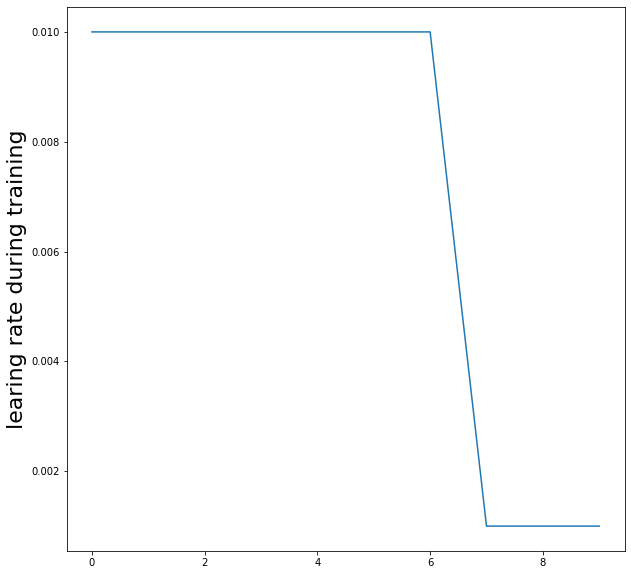

In [30]:
plt.figure(figsize=(10,10))
plt.plot([i[0] for i in lr_rate_list])
plt.ylabel('learing rate during training', fontsize=22)
plt.show()

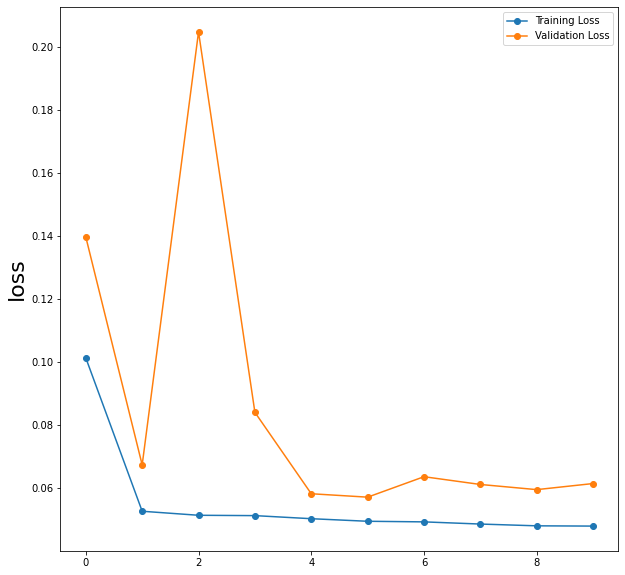

In [31]:
plt.figure(figsize=(10,10))
plt.plot(train_loss_list,  marker='o', label="Training Loss")
plt.plot(valid_loss_list,  marker='o', label="Validation Loss")
plt.ylabel('loss', fontsize=22)
plt.legend()
plt.show()

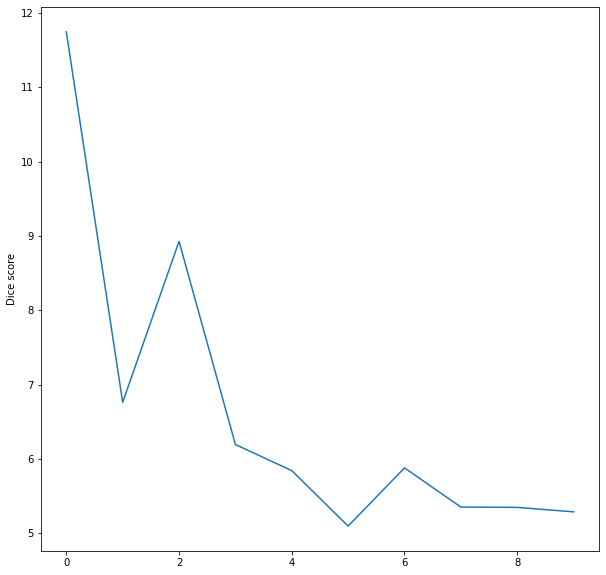

In [32]:
plt.figure(figsize=(10,10))
plt.plot(dice_score_list)
plt.ylabel('Dice score')
plt.show()

In [14]:
def binarize_labels(x, num_classes):
    x_bin = torch.zeros_like(x).repeat(1, num_classes, 1, 1)
    for i in range(num_classes):
        x_bin[:, i:i + 1][(x == i).unsqueeze(0)] = 1.0
    return x_bin

def one_hot(x):
    C = x.size()[1]
    x = nn.functional.one_hot(torch.argmax(x, dim=1), num_classes=C)
    return x.permute(0, 3, 1, 2)
    
def dice_metric(prediction, target):
    N, C, H, W = prediction.size()
    spatial_dims = (2, 3)

    # sets the highest prediction to 1, all others to 0
    prediction = one_hot(prediction)
    target = binarize_labels(target, C)

    overlap = torch.sum(prediction * target, dim=spatial_dims)
    total = torch.sum(target, dim=spatial_dims) + torch.sum(prediction, dim=spatial_dims)

    dice_coeffs = 2 * overlap / total.float()

    return dice_coeffs

In [15]:
# load best model
model = UNet(3,3)
model.load_state_dict(torch.load('drive/Shared drives/Capstone Summer 2020/Models/Unet_From_Scratch/Laroy_UNet_final.pth'))
model.eval();

UNIQUE MASK: [0 1 2]
torch.Size([1, 3, 408, 408])
torch.Size([1, 408, 408])
torch.Size([408, 408])
(408, 408)
1.6829834 6.346108 -3.5606594
-4.7612715 1.1621133 -8.67278
[[-4.3105617 -3.8195727 -3.7060826 ... -3.6909673 -3.7687752 -4.2499313]
 [-3.7994375 -3.7224174 -4.0923395 ... -4.05895   -3.7330124 -3.6903327]
 [-3.6586294 -4.066597  -4.521094  ... -4.4806237 -4.0756373 -3.669122 ]
 ...
 [-3.647216  -4.052595  -4.510531  ... -4.469941  -4.0676274 -3.6680608]
 [-3.746487  -3.7042353 -4.062061  ... -4.0368986 -3.7299483 -3.6802511]
 [-4.2290277 -3.684113  -3.636064  ... -3.627096  -3.676353  -4.176938 ]]
[[4.8029227 4.15394   4.202024  ... 4.226292  4.1781883 4.813751 ]
 [4.1224484 4.499558  5.126697  ... 5.1412    4.554641  4.1593575]
 [4.142098  5.0913353 5.8851485 ... 5.8950143 5.1628995 4.2630873]
 ...
 [4.1420183 5.0867715 5.8807664 ... 5.8899097 5.1603856 4.2693386]
 [4.1074433 4.5084705 5.105258  ... 5.1192007 4.5772457 4.1816864]
 [4.7659407 4.0891967 4.189008  ... 4.219576  

Text(0.5, 1.0, 'GT')

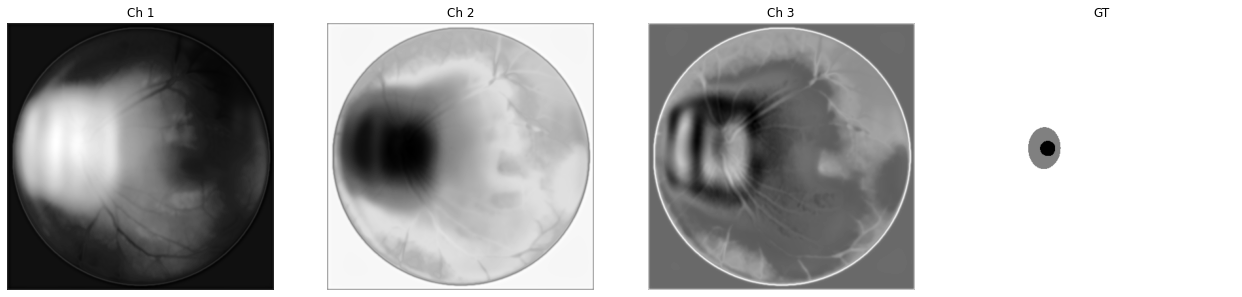

In [24]:
imageName = "V0200"
folderName= "Validation"

img_path = "drive/Shared drives/Capstone Summer 2020/Data/"+ folderName +"/Images/"+ imageName +".jpg"
img = Image.open(img_path).convert("RGB")
img = torch.from_numpy(Dataset.preprocess(img, 0.25))
img = img.unsqueeze(0)
img = img.to(dtype=torch.float32)

mask_path = "drive/Shared drives/Capstone Summer 2020/Data/"+ folderName +"/Masks/"+ imageName +".bmp"
ground_truth = Image.open(mask_path)


ground_truth = Dataset.preprocess(ground_truth, 0.25)*2

# ground_truth = ground_truth.resize((408, 408), resample=Image.NEAREST)
# ground_truth = fix_mask(np.array(ground_truth))
ground_truth = torch.from_numpy(ground_truth).long()[0]
print("UNIQUE MASK:", np.unique(ground_truth))

with torch.no_grad():
  result = model(img)
  print(result.shape)

  mask = torch.argmax(result, dim=1)
  print(mask.shape)

  mask = mask[0]
  print(mask.shape)

  full_mask = mask.detach().cpu().numpy()
  print(full_mask.shape)


# with torch.no_grad():
#   result = model(img)
#   torch.
#   probs = torch.nn.functional.softmax(result, dim=1)
#   probs = probs.squeeze(0)
#   # probs = tf(probs.cpu())
#   full_mask = probs.squeeze().cpu().numpy()


# with torch.no_grad():
#   result = model(img)
#   probs = torch.nn.functional.softmax(result, dim=1)
#   probs = probs.squeeze(0)
#   # probs = tf(probs.cpu())
#   full_mask = probs.squeeze().cpu().numpy()

#Plotting all predicted masks
ch1_mask = result[0][0].detach().cpu().numpy()
ch2_mask = result[0][1].detach().cpu().numpy()
ch3_mask = result[0][2].detach().cpu().numpy()

fig, axs = plt.subplots(1, 4, figsize=(22,5))

print(max(ch1_mask.flatten()), max(ch2_mask.flatten()), max(ch3_mask.flatten()))
print(min(ch1_mask.flatten()), min(ch2_mask.flatten()), min(ch3_mask.flatten()))
print(ch1_mask)
print(ch2_mask)
print(ch3_mask)

#plot original image
axs[0].imshow((ch1_mask), cmap='gray')
axs[0].axis('off')   
axs[0].set_title('Ch 1')

#plot ground truth
axs[1].imshow((ch2_mask), cmap='gray')
axs[1].axis('off')   
axs[1].set_title('Ch 2')

#plot the mask
axs[2].imshow((ch3_mask), cmap='gray')
axs[2].axis('off')   
axs[2].set_title('Ch 3')

axs[3].imshow((ground_truth), cmap='gray')
axs[3].axis('off')   
axs[3].set_title('GT')


In [25]:
dice_metric(result, ground_truth.unsqueeze(0))

tensor([[0.3243, 0.0160, 0.0000]])

[0 1]


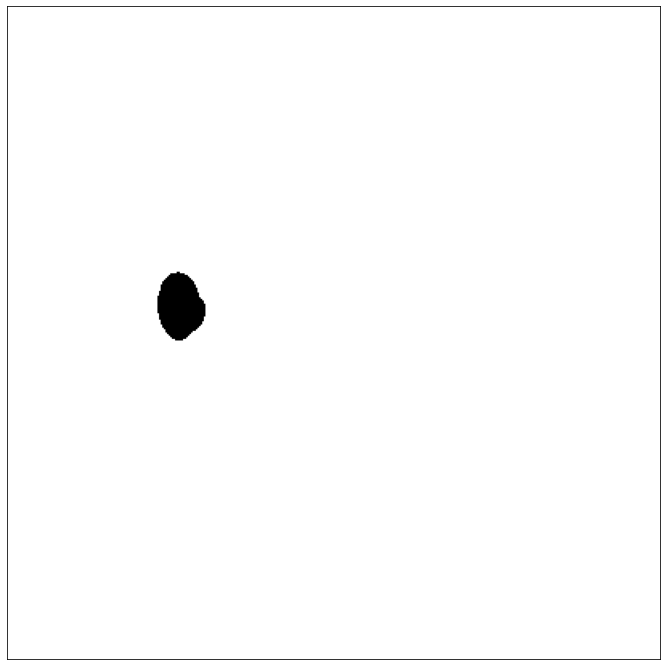

In [18]:
print(np.unique(full_mask))

plt.figure(figsize=(12, 12))
plt.tick_params(which='both', bottom=False, top=False, left=False, labelbottom=False, labelleft=False)
plt.imshow(full_mask, cmap="gray")

torch.Size([3, 408, 408])


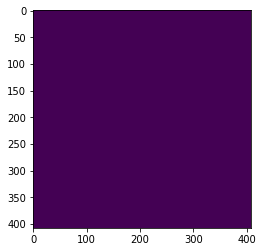

In [19]:
testicles = result.argmax(dim=0)
print(testicles.shape)
plt.imshow(testicles[1]*-255)